## Imports

In [4]:
!sudo pip3 install torch

[sudo] password for f006dg0: 


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io as sio
from torchvision.models import resnet50
import numpy as np

ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python setup.py install && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python setup.py develop && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [2]:
def getHandwritingCharacterDefinitions():
    """
    Returns a dictionary with entries that define the names of each character, its length, and where the pen tip begins.
    
    Returns:
        charDef (dict)
    """
        
    charDef = {}
    
    #Define the list of all 31 characters and their names.
    charDef['charList'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                'greaterThan','comma','apostrophe','tilde','questionMark']
    charDef['charListAbbr'] = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                '>',',',"'",'~','?']

    #Define the length of each character (in # of 10 ms bins) to use for each template.
    #These were hand-defined based on visual inspection of the reconstructed pen trajectories.
    charDef['charLen'] = np.array([99, 91, 70, 104, 98, 125, 110, 104, 79, 92, 127, 68, 132, 90, 
                        84, 113, 104, 74, 86, 110, 86, 83, 110, 103, 115, 100, 82, 77, 116, 71, 110]).astype(np.int32)
    
    #For each character, this defines the starting location of the pen tip (0 = bottom of the line, 1 = top)
    charDef['penStart'] = [0.25, 1, 0.5, 0.5, 0.25, 1.0, 0.25, 1.0, 0.5, 0.5, 1, 1, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 1, 
           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 1, 0.5, 1]
    
    #dictionary to convert string representation to character index
    charDef['strToCharIdx'] = {}
    for x in range(len(charDef['charListAbbr'])):
        charDef['strToCharIdx'][charDef['charListAbbr'][x]] = x
        
    #ordering of characters that kaldi (i.e., the language model) expects
    charDef['kaldiOrder'] = ['<ctc>','>',"'",',','.','?','a','b','c','d','e','f','g','h','i','j',
                             'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    
    #re-indexing to match kaldi order (e.g., outputs[:,:,charDef['idxToKaldi']] places the output in kald-order)
    charDef['idxToKaldi'] = np.array([31,26,28,27,29,30,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                                     21,22,23,24,25]).astype(np.int32)
    
    return charDef

## Load the Dataset

In [3]:
topDirs = ['Datasets']
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']
charDef = getHandwritingCharacterDefinitions()

In [4]:
all_tensors = []
all_labels = []
for directory in dataDirs:
    
    mat = f'./handwritingBCIData/Datasets/{directory}/singleLetters.mat'
    data = sio.loadmat(mat)
    ctr = 0
    for letter in charDef['charList']:
        t = torch.Tensor(data[f'neuralActivityCube_{letter}'])
        qty = t.shape[0]
        labels = torch.Tensor([ctr]*qty)
        ctr += 1
#         if t.shape[0] == 27:
        all_tensors.append(t)
        all_labels.append(labels)

tensor_data = torch.cat(all_tensors, dim=0)
tensor_data = np.repeat(tensor_data[..., np.newaxis], 3, -1).transpose(-1,-2).transpose(-2,-3)

# tensor_data = tensor_data.transpose(-1,0).transpose(-1,-2)
tensor_labels = torch.cat(all_labels).long()


In [5]:
# tensor_data=rgb_data
tensor_data.shape

torch.Size([3627, 3, 201, 192])

In [6]:
from torch.utils.data import random_split


dataset = TensorDataset(tensor_data, tensor_labels)
train_data, test_data = random_split(dataset, [3000, 627])
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
# The ViT model
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, embedding_dim, num_heads, num_layers):
        super(ViT, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.flatten = nn.Flatten(start_dim=2)
        self.embedding = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        self.positional_embedding = nn.Parameter(torch.rand(1, self.num_patches + 1, embedding_dim))
        encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        print(f"Input shape (x): {x.shape}")
        
        x = x.permute(0, 2, 3, 1)
        x = x.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.patch_size * self.patch_size * 3)
        x = self.flatten(x)
        x = self.embedding(x)

        print(f"Positional embedding shape: {self.positional_embedding.shape}")
        
        x = x + self.positional_embedding
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [8]:
# Step 4: Model Compilation
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model = MyCNN(31)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=model.to(device)

cuda:1


/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg_cache_f006dg0/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.0MB/s]


In [9]:
num_epochs = 100
batch_size = 32

In [10]:
for epoch in range(num_epochs):
    model.train()
    print(f'epoch {epoch}')
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels= labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)  # Add a channel dimension to the input
        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()
    
    # Step 6: Model Evaluation
    model.eval()
    with torch.no_grad():
        cumulative_accuracy = torch.tensor([]).to(device)
        for batch in test_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = model(inputs).to(device)
            val_loss = criterion(val_outputs, labels).to(device)
            val_predictions = torch.argmax(val_outputs, dim=1).to(device)
            val_accuracy = (val_predictions == labels).float().to(device)
            cumulative_accuracy = torch.cat([cumulative_accuracy,val_accuracy], dim=0).to(device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {cumulative_accuracy.mean().item():.4f}")

epoch 0
Epoch 1/100, Validation Loss: 6.3974, Validation Accuracy: 0.0144
epoch 1
Epoch 2/100, Validation Loss: 3.4394, Validation Accuracy: 0.0558
epoch 2
Epoch 3/100, Validation Loss: 3.3353, Validation Accuracy: 0.0909
epoch 3
Epoch 4/100, Validation Loss: 4.7791, Validation Accuracy: 0.1069
epoch 4
Epoch 5/100, Validation Loss: 2.5833, Validation Accuracy: 0.1340
epoch 5
Epoch 6/100, Validation Loss: 2.4912, Validation Accuracy: 0.2919
epoch 6
Epoch 7/100, Validation Loss: 1.5777, Validation Accuracy: 0.3971
epoch 7
Epoch 8/100, Validation Loss: 1.9828, Validation Accuracy: 0.4657
epoch 8
Epoch 9/100, Validation Loss: 1.3649, Validation Accuracy: 0.4450
epoch 9
Epoch 10/100, Validation Loss: 1.7004, Validation Accuracy: 0.5183
epoch 10
Epoch 11/100, Validation Loss: 1.0500, Validation Accuracy: 0.5981
epoch 11
Epoch 12/100, Validation Loss: 1.8050, Validation Accuracy: 0.6443
epoch 12
Epoch 13/100, Validation Loss: 0.7346, Validation Accuracy: 0.6699
epoch 13
Epoch 14/100, Validati

In [11]:
torch.save(model.state_dict(), './resnet_single_chars_norm.pth')

In [12]:
model.load_state_dict(torch.load('./resnet_single_chars_norm.pth', map_location='cpu'))
sd = model.state_dict()
for k, v in sd.items():
    print("{:20s} {}".format(k, v.shape))

resnet.conv1.weight  torch.Size([64, 3, 7, 7])
resnet.bn1.weight    torch.Size([64])
resnet.bn1.bias      torch.Size([64])
resnet.bn1.running_mean torch.Size([64])
resnet.bn1.running_var torch.Size([64])
resnet.bn1.num_batches_tracked torch.Size([])
resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
resnet.layer1.0.bn1.weight torch.Size([64])
resnet.layer1.0.bn1.bias torch.Size([64])
resnet.layer1.0.bn1.running_mean torch.Size([64])
resnet.layer1.0.bn1.running_var torch.Size([64])
resnet.layer1.0.bn1.num_batches_tracked torch.Size([])
resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
resnet.layer1.0.bn2.weight torch.Size([64])
resnet.layer1.0.bn2.bias torch.Size([64])
resnet.layer1.0.bn2.running_mean torch.Size([64])
resnet.layer1.0.bn2.running_var torch.Size([64])
resnet.layer1.0.bn2.num_batches_tracked torch.Size([])
resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
resnet.layer1.0.bn3.weight torch.Size([256])
resnet.layer1.0.bn3.bias torch.Size([256])
resnet.layer1

In [13]:
model

MyCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

CNN Model inference

In [18]:
from torch.utils.data import random_split

dataset = TensorDataset(tensor_labels, tensor_data)
train_data, test_data = random_split(dataset, [3000, 627])
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [19]:
# Step 4: Model Compilation
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model = MyCNN(31)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=model.to(device)

cuda:1


In [20]:
num_epochs = 100
batch_size = 32

In [ ]:
for epoch in range(num_epochs):
    model.train()
    print(f'epoch {epoch}')
    for batch in train_dataloader:
        labels, inputs = batch  # Switched labels and inputs
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)  # Add a channel dimension to the input
        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()
    
    # Step 6: Model Evaluation
    model.eval()
    with torch.no_grad():
        cumulative_accuracy = torch.tensor([]).to(device)
        for batch in test_dataloader:
            labels, inputs = batch  # Switched labels and inputs
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = model(inputs).to(device)
            val_loss = criterion(val_outputs, labels).to(device)
            val_predictions = torch.argmax(val_outputs, dim=1).to(device)
            val_accuracy = (val_predictions == labels).float().to(device)
            cumulative_accuracy = torch.cat([cumulative_accuracy, val_accuracy], dim=0).to(device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {cumulative_accuracy.mean().item():.4f}")

In [ ]:
import timm

# Define your custom ViT model for the encoder
class MyViT(nn.Module):
    def __init__(self, num_classes):
        super(MyViT, self).__init()
        self.encoder = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.decoder = nn.Sequential(
            nn.Linear(self.encoder.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Your existing code for loading data
mat2 = './handwritingBCIData/Datasets/t5.2019.05.08/sentences.mat'
data2 = sio.loadmat(mat2)
sentence_tensors = torch.Tensor(data2['neuralActivityCube'])

# Create an empty list to store tokenized text
tokenized_texts = []

# Tokenize each intended text
for intended_text_array in data2['intendedText']:
    intended_text = [str(item[0]) for item in intended_text_array]
    tokenized_texts.append(intended_text)

# Convert tokenized_texts into a NumPy array
tokenized_texts_array = np.array(tokenized_texts)

# Create a list to store the sentences as lists of characters
sentences_as_char_lists = []

# Iterate through each string in the array
for text in tokenized_texts_array:
    char_list = []
    for sentence in text:
        for char in sentence:
            char_list.append(char)
    sentences_as_char_lists.append(char_list)

sequence = []

# Print the list of sentences as lists of characters
for char_list in sentences_as_char_lists:
    sequence.append(char_list)

In [ ]:
print(sequence)

[['t', 'h', 'a', 'n', 'k', 's', '>', 's', 'o', '>', 'm', 'u', 'c', 'h', ',', '>', 'h', 'o', 'n', 'e', 'y', '~'], ['b', 'u', 't', '>', 't', 'h', 'a', 't', '>', 's', 'e', 'e', 'm', 'e', 'd', '>', 't', 'o', '>', 'h', 'i', 'm', '>', 't', 'o', '>', 'b', 'e', '>', 't', 'h', 'e', '>', 'w', 'o', 'r', 's', 't', '>', 'p', 'o', 's', 's', 'i', 'b', 'l', 'e', '>', 't', 'a', 'c', 't', 'i', 'c', '>', 't', 'o', '>', 'e', 'm', 'p', 'l', 'o', 'y', '~'], ['y', 'o', 'u', '>', 'w', 'a', 'n', 't', '>', 'm', 'e', '>', 't', 'o', '>', 's', 'i', 'n', 'g', '?'], ['t', 'h', 'e', '>', 'b', 'o', 'y', 'c', 'o', 't', 't', '>', 'd', 'i', 'd', 'n', "'", 't', '>', 'a', 'p', 'p', 'e', 'a', 'r', '>', 't', 'o', '>', 'h', 'a', 'v', 'e', '>', 'h', 'u', 'r', 't', '>', 't', 'h', 'e', 'i', 'r', '>', 'b', 'u', 's', 'i', 'n', 'e', 's', 's', '>', 'o', 'n', 'e', '>', 'b', 'i', 't', '~'], ['t', 'h', 'a', 't', "'", 's', '>', 'a', '>', 'p', 'r', 'o', 'm', 'i', 's', 'e', '~'], ['h', 'a', 'v', 'e', '>', 'y', 'o', 'u', '>', 'e', 'v', 'e'

In [ ]:
# Training loop
num_epochs = 10  # Specify the number of training epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # Get the inputs and labels from the data loader
        inputs, *text_inputs = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Replace with your model's forward pass

        # Compute the loss
        loss = criterion(outputs, labels)  # Modify labels based on your data

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the loss for this epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Finished Training")

In [ ]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])


In [ ]:
backward_hook = model.resnet.layer4[-1].register_full_backward_hook(backward_hook)
forward_hook = model.resnet.layer4[-1].register_forward_hook(forward_hook)

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL


def gradCAM(model, example, class_, pth):
    x = model(example)
    criterion(x, torch.tensor([class_]).to(device)).backward()
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())
    # Create a figure and plot the first image
    fig, ax = plt.subplots()
    ax.axis('off') # removes the axis markers

    # First plot the original image
    ax.imshow(to_pil_image(example.squeeze(0), mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest', extent=(0,example.shape[-1],example.shape[-2],0))

    # Show the plot
#     plt.show()
    plt.savefig(pth)
    return plt

In [ ]:
import os

root = './grad_cam_images'
if not os.path.exists(root):
    os.mkdir(root)

for directory in dataDirs[:2]:
    matS = f'./handwritingBCIData/Datasets/{directory}/sentences.mat'
    matL = f'./handwritingBCIData/Datasets/{directory}/singleLetters.mat'

    dataS = sio.loadmat(matS)
    dataL = sio.loadmat(matL)

    class_ctr = 0

    sentence_data = torch.Tensor(dataS['neuralActivityCube'])

    # Iterate through the characters
    for letter in charDef['charList']:
        letter_data = torch.Tensor(dataL[f'neuralActivityCube_{letter}'])
        
        # Iterate through the characters in the sentence_data
        for char in sentence_data:
            # Iterate through the possible letters
            for ex in letter_data:
                ex = np.repeat(ex[..., np.newaxis], 3, -1).transpose(-1,-2).transpose(-2,-3).unsqueeze(0).to(device)
                
                # Use the model to make predictions for 'char' and 'ex'
                # Assuming your model takes an image tensor and predicts a letter
                char_prediction = model(char)
                ex_prediction = model(ex)

                # Compare the predictions to see if they match
                if torch.equal(char_prediction, ex_prediction):
                    # Assuming 'pth' and 'model' are defined somewhere
                    # Use gradCAM function to generate visualizations
                    plt = gradCAM(model, ex, class_ctr, pth)
        class_ctr += 1


In [ ]:
backward_hook.remove()
forward_hook.remove()

31


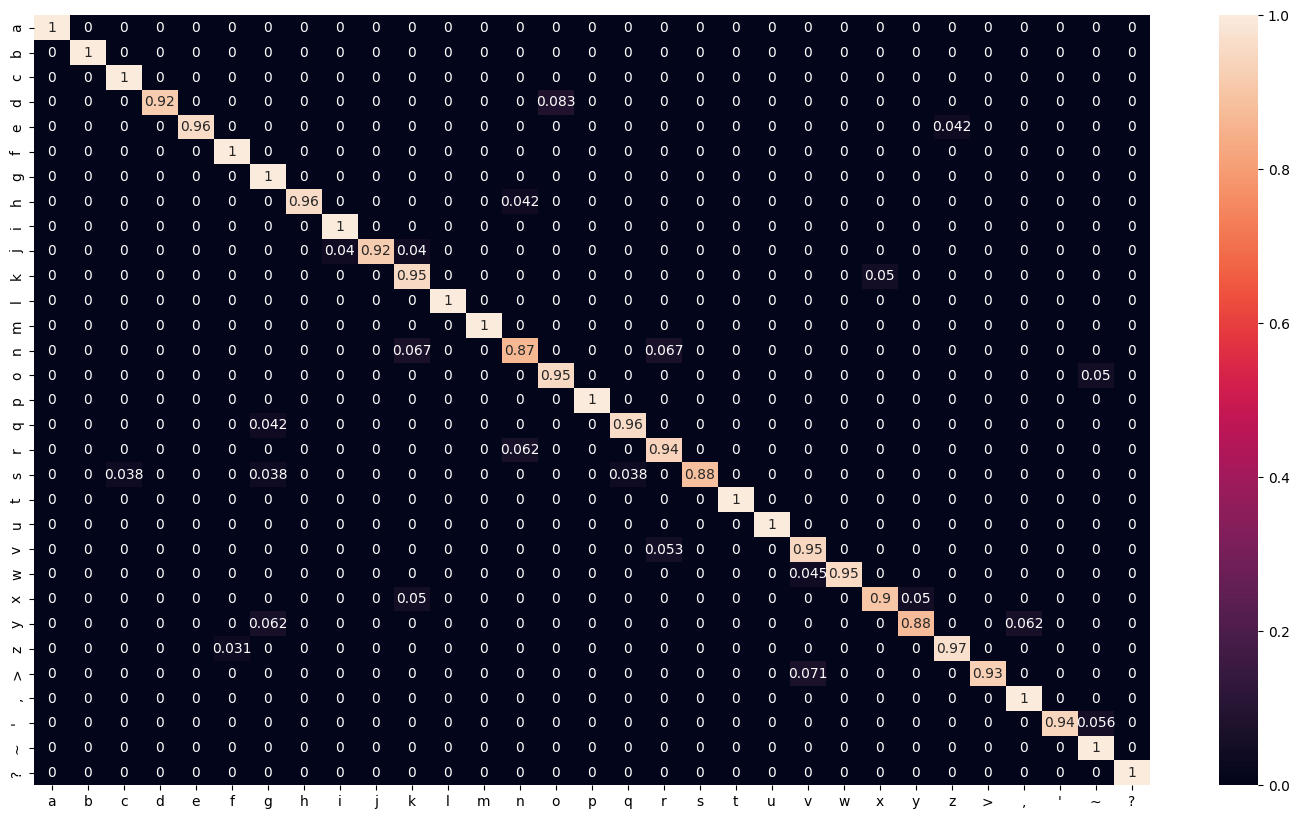

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = charDef['charList']
classes = classes[:-5] + ['>', ',', '\'', '~', '?']
print(len(classes))
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24//1.3,14//1.3))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')